<a href="https://colab.research.google.com/github/shiling2007/Python-/blob/main/Python_Control_Systems_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://deeplizard.com/learn/video/lu7TCu7HeYc

from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# from google.colab import drive
# drive.mount('/content/drive')
# from google.colab import files
# files.download('/content/drive/MyDrive/Colab Notebooks/Lease Payment Formula.ipynb') 
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.5g" % x))
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 999)
pd.set_option("max_colwidth", 500)
# try:
#  device_name = os.environ['COLAB_TPU_ADDR']
#  TPU_ADDRESS = 'grpc://' + device_name
#  print('Found TPU at: {}'.format(TPU_ADDRESS))
# except KeyError:
#  print('TPU not found')
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install slycot 
!pip install control

     |████████████████████████████████| 1.5 MB 6.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1418258 sha256=d042b6b279369a76cc3ed8588486951f2340ed7d9f45a55201c1ebbaa7b6ee29
  Stored in directory: /root/.cache/pip/wheels/fa/b2/19/1e6568896fbabaf2a03d2fb6575211d281afcb9e00ce026cf6
Successfully built slycot
     |████████████████████████████████| 357 kB 33.2 MB/s 
  Created wheel for control: filename=control-0.9.1-py2.py3-none-any.whl size=364703 sha256=a507183b3dd77fcf3ff1829200f5a895acaa8b0259e9ff4420d315428afb6657
  Stored in directory: /root/.cache/pip/wheels/b1/50/22/8005107713828997d1af664fbd629c7f935a1b87fc2f4ba6c1
Successfully built control


In [ ]:
# Cruise control

import numpy as np
import matplotlib.pyplot as plt
from math import pi
import control as ct

In [ ]:
def vehicle_update(t, x, u, params={}):
    """Vehicle dynamics for cruise control system.

    Parameters
    ----------
    x : array
         System state: car velocity in m/s
    u : array
         System input: [throttle, gear, road_slope], where throttle is
         a float between 0 and 1, gear is an integer between 1 and 5,
         and road_slope is in rad.

    Returns
    -------
    float
        Vehicle acceleration

    """
    from math import copysign, sin
    sign = lambda x: copysign(1, x)         # define the sign() function

    # Set up the system parameters
    m = params.get('m', 1600.)              # vehicle mass, kg
    g = params.get('g', 9.8)                # gravitational constant, m/s^2
    Cr = params.get('Cr', 0.01)             # coefficient of rolling friction
    Cd = params.get('Cd', 0.32)             # drag coefficient
    rho = params.get('rho', 1.3)            # density of air, kg/m^3
    A = params.get('A', 2.4)                # car area, m^2
    alpha = params.get(
        'alpha', [40, 25, 16, 12, 10])      # gear ratio / wheel radius

    # Define variables for vehicle state and inputs
    v = x[0]                           # vehicle velocity
    throttle = np.clip(u[0], 0, 1)     # vehicle throttle
    gear = u[1]                        # vehicle gear
    theta = u[2]                       # road slope

    # Force generated by the engine

    omega = alpha[int(gear)-1] * v      # engine angular speed
    F = alpha[int(gear)-1] * motor_torque(omega, params) * throttle

    # Disturbance forces
    #
    # The disturbance force Fd has three major components: Fg, the forces due
    # to gravity; Fr, the forces due to rolling friction; and Fa, the
    # aerodynamic drag.

    # Letting the slope of the road be \theta (theta), gravity gives the
    # force Fg = m g sin \theta.

    Fg = m * g * sin(theta)

    # A simple model of rolling friction is Fr = m g Cr sgn(v), where Cr is
    # the coefficient of rolling friction and sgn(v) is the sign of v (±1) or
    # zero if v = 0.

    Fr  = m * g * Cr * sign(v)

    # The aerodynamic drag is proportional to the square of the speed: Fa =
    # 1/2 \rho Cd A |v| v, where \rho is the density of air, Cd is the
    # shape-dependent aerodynamic drag coefficient, and A is the frontal area
    # of the car.

    Fa = 1/2 * rho * Cd * A * abs(v) * v

    # Final acceleration on the car
    Fd = Fg + Fr + Fa
    dv = (F - Fd) / m

    return dv

In [ ]:
def motor_torque(omega, params={}):
    # Set up the system parameters
    Tm = params.get('Tm', 190.)             # engine torque constant
    omega_m = params.get('omega_m', 420.)   # peak engine angular speed
    beta = params.get('beta', 0.4)          # peak engine rolloff

    return np.clip(Tm * (1 - beta * (omega/omega_m - 1)**2), 0, None)

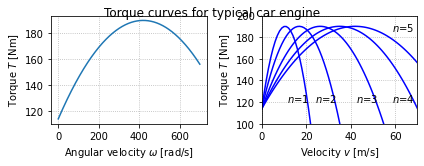

In [ ]:
# Figure 4.2a - single torque curve as function of omega
omega_range = np.linspace(0, 700, 701)
plt.subplot(2, 2, 1)
plt.plot(omega_range, [motor_torque(w) for w in omega_range])
plt.xlabel('Angular velocity $\omega$ [rad/s]')
plt.ylabel('Torque $T$ [Nm]')
plt.grid(True, linestyle='dotted')

# Figure 4.2b - torque curves in different gears, as function of velocity
plt.subplot(2, 2, 2)
v_range = np.linspace(0, 70, 71)
alpha = [40, 25, 16, 12, 10]
for gear in range(5):
    omega_range = alpha[gear] * v_range
    plt.plot(v_range, [motor_torque(w) for w in omega_range],
             color='blue', linestyle='solid')

# Set up the axes and style
plt.axis([0, 70, 100, 200])
plt.grid(True, linestyle='dotted')

# Add labels
plt.text(11.5, 120, '$n$=1')
plt.text(24, 120, '$n$=2')
plt.text(42.5, 120, '$n$=3')
plt.text(58.5, 120, '$n$=4')
plt.text(58.5, 185, '$n$=5')
plt.xlabel('Velocity $v$ [m/s]')
plt.ylabel('Torque $T$ [Nm]')

plt.tight_layout()
plt.suptitle('Torque curves for typical car engine');

In [ ]:
vehicle = ct.NonlinearIOSystem(
    vehicle_update, None, name='vehicle',
    inputs = ('u', 'gear', 'theta'), outputs = ('v'), states=('v'))

# Define a generator for creating a "standard" cruise control plot
def cruise_plot(sys, t, y, t_hill=5, vref=20, antiwindup=False, linetype='b-',
               subplots=[None, None]):
    # Figure out the plot bounds and indices
    v_min = vref-1.2; v_max = vref+0.5; v_ind = sys.find_output('v')
    u_min = 0; u_max = 2 if antiwindup else 1; u_ind = sys.find_output('u')

    # Make sure the upper and lower bounds on v are OK
    while max(y[v_ind]) > v_max: v_max += 1
    while min(y[v_ind]) < v_min: v_min -= 1

    # Create arrays for return values
    subplot_axes = subplots.copy()

    # Velocity profile
    if subplot_axes[0] is None:
        subplot_axes[0] = plt.subplot(2, 1, 1)
    else:
        plt.sca(subplots[0])
    plt.plot(t, y[v_ind], linetype)
    plt.plot(t, vref*np.ones(t.shape), 'k-')
    plt.plot([t_hill, t_hill], [v_min, v_max], 'k--')
    plt.axis([0, t[-1], v_min, v_max])
    plt.xlabel('Time $t$ [s]')
    plt.ylabel('Velocity $v$ [m/s]')

    # Commanded input profile
    if subplot_axes[1] is None:
        subplot_axes[1] = plt.subplot(2, 1, 2)
    else:
        plt.sca(subplots[1])
    plt.plot(t, y[u_ind], 'r--' if antiwindup else linetype)
    plt.plot([t_hill, t_hill], [u_min, u_max], 'k--')
    plt.axis([0, t[-1], u_min, u_max])
    plt.xlabel('Time $t$ [s]')
    plt.ylabel('Throttle $u$')

    # Applied input profile
    if antiwindup:
        plt.plot(t, np.clip(y[u_ind], 0, 1), linetype)
        plt.legend(['Commanded', 'Applied'], frameon=False)

    return subplot_axes

In [ ]:
def sf_update(t, z, u, params={}):
    y, r = u[1], u[2]
    return y - r

def sf_output(t, z, u, params={}):
    # Get the controller parameters that we need
    K = params.get('K', 0)
    ki = params.get('ki', 0)
    kf = params.get('kf', 0)
    xd = params.get('xd', 0)
    yd = params.get('yd', 0)
    ud = params.get('ud', 0)

    # Get the system state and reference input
    x, y, r = u[0], u[1], u[2]

    return ud - K * (x - xd) - ki * z + kf * (r - yd)

# Create the input/output system for the controller
control_sf = ct.NonlinearIOSystem(
    sf_update, sf_output, name='control',
    inputs=('x', 'y', 'r'),
    outputs=('u'),
    states=('z'))

# Create the closed loop system for the state space controller
cruise_sf = ct.InterconnectedSystem(
    (vehicle, control_sf), name='cruise',
    connections=(
        ('vehicle.u', 'control.u'),
        ('control.x', 'vehicle.v'),
        ('control.y', 'vehicle.v')),
    inplist=('control.r', 'vehicle.gear', 'vehicle.theta'),
    outlist=('control.u', 'vehicle.v'), outputs=['u', 'v'])

# Define the time and input vectors
T = np.linspace(0, 25, 501)
vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta0 = np.zeros(T.shape)

# Find the equilibrium point for the system
Xeq, Ueq = ct.find_eqpt(
    vehicle, [vref[0]], [0, gear[0], theta0[0]], y0=[vref[0]], iu=[1, 2])
print("Xeq = ", Xeq)
print("Ueq = ", Ueq)

# Compute the linearized system at the eq pt
cruise_linearized = ct.linearize(vehicle, Xeq, [Ueq[0], gear[0], 0])



Xeq =  [20]
Ueq =  [0.16875 4 0]


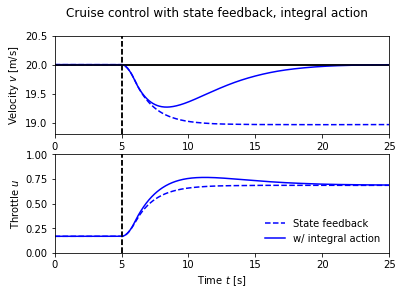

In [ ]:
# Construct the gain matrices for the system
A, B, C = cruise_linearized.A, cruise_linearized.B[0, 0], cruise_linearized.C
K = 0.5
kf = -1 / (C * np.linalg.inv(A - B * K) * B)

# Compute the steady state velocity and throttle setting
xd = Xeq[0]
ud = Ueq[0]
yd = vref[-1]

# Response of the system with no integral feedback term
plt.figure()
theta_hill = [
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T]
t, y_sfb = ct.input_output_response(
    cruise_sf, T, [vref, gear, theta_hill], [Xeq[0], 0],
    params={'K':K, 'ki':0.0, 'kf':kf, 'xd':xd, 'ud':ud, 'yd':yd})
subplots = cruise_plot(cruise_sf, t, y_sfb, t_hill=5, linetype='b--')

# Response of the system with state feedback + integral action
t, y_sfb_int = ct.input_output_response(
    cruise_sf, T, [vref, gear, theta_hill], [Xeq[0], 0],
    params={'K':K, 'ki':0.1, 'kf':kf, 'xd':xd, 'ud':ud, 'yd':yd})
cruise_plot(cruise_sf, t, y_sfb_int, t_hill=5, linetype='b-', subplots=subplots)

# Add title and legend
plt.suptitle('Cruise control with state feedback, integral action')
import matplotlib.lines as mlines
p_line = mlines.Line2D([], [], color='blue', linestyle='--', label='State feedback')
pi_line = mlines.Line2D([], [], color='blue', linestyle='-', label='w/ integral action')
plt.legend(handles=[p_line, pi_line], frameon=False, loc='lower right');

system: a =  0.010124405669387215 , b =  1.3203061238159202
pzcancel: kp = 0.5 , ki = 0.005062202834693608 , 1/(kp b) =  1.5148002148317266
sfb_int: K =  0.5 , ki = 0.1


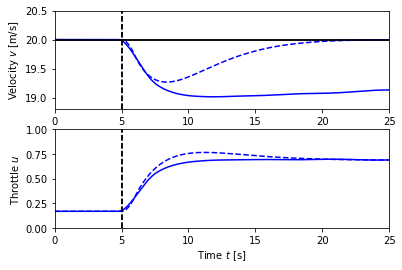

In [ ]:
# Get the transfer function from throttle input + hill to vehicle speed
P = ct.ss2tf(cruise_linearized[0, 0])

# Construction a controller that cancels the pole
kp = 0.5
a = -P.pole()[0]
b = np.real(P(0)) * a
ki = a * kp
C = ct.tf2ss(ct.TransferFunction([kp, ki], [1, 0]))
control_pz = ct.LinearIOSystem(C, name='control', inputs='u', outputs='y')
print("system: a = ", a, ", b = ", b)
print("pzcancel: kp =", kp, ", ki =", ki, ", 1/(kp b) = ", 1/(kp * b))
print("sfb_int: K = ", K, ", ki = 0.1")

# Construct the closed loop system and plot the response
# Create the closed loop system for the state space controller
cruise_pz = ct.InterconnectedSystem(
    (vehicle, control_pz), name='cruise_pz',
    connections = (
        ('control.u', '-vehicle.v'),
        ('vehicle.u', 'control.y')),
    inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'),
    inputs = ('vref', 'gear', 'theta'),
    outlist = ('vehicle.v', 'vehicle.u'),
    outputs = ('v', 'u'))

# Find the equilibrium point
X0, U0 = ct.find_eqpt(
    cruise_pz, [vref[0], 0], [vref[0], gear[0], theta0[0]],
    iu=[1, 2], y0=[vref[0], 0], iy=[0])

# Response of the system with PI controller canceling process pole
t, y_pzcancel = ct.input_output_response(
    cruise_pz, T, [vref, gear, theta_hill], X0)
subplots = cruise_plot(cruise_pz, t, y_pzcancel, t_hill=5, linetype='b-')
cruise_plot(cruise_sf, t, y_sfb_int, t_hill=5, linetype='b--', subplots=subplots);

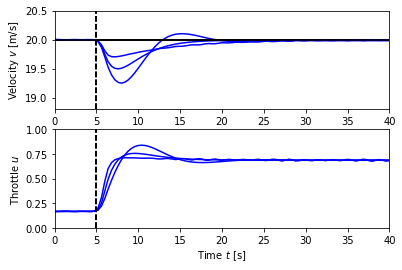

In [ ]:
# Values of the first order transfer function P(s) = b/(s + a) are set above

# Define the input that we want to track
T = np.linspace(0, 40, 101)
vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta_hill = np.array([
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T])

# Fix \omega_0 and vary \zeta
w0 = 0.5
subplots = [None, None]
for zeta in [0.5, 1, 2]:
    # Create the controller transfer function (as an I/O system)
    kp = (2*zeta*w0 - a)/b
    ki = w0**2 / b
    control_tf = ct.tf2io(
        ct.TransferFunction([kp, ki], [1, 0.01*ki/kp]),
        name='control', inputs='u', outputs='y')

    # Construct the closed loop system by interconnecting process and controller
    cruise_tf = ct.InterconnectedSystem(
    (vehicle, control_tf), name='cruise',
    connections = [('control.u', '-vehicle.v'), ('vehicle.u', 'control.y')],
    inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'),
        inputs = ('vref', 'gear', 'theta'),
    outlist = ('vehicle.v', 'vehicle.u'), outputs = ('v', 'u'))

    # Plot the velocity response
    X0, U0 = ct.find_eqpt(
        cruise_tf, [vref[0], 0], [vref[0], gear[0], theta_hill[0]],
        iu=[1, 2], y0=[vref[0], 0], iy=[0])

    t, y = ct.input_output_response(cruise_tf, T, [vref, gear, theta_hill], X0)
    subplots = cruise_plot(cruise_tf, t, y, t_hill=5, subplots=subplots)

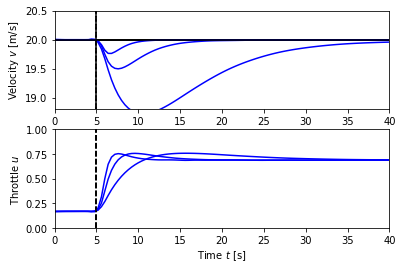

In [ ]:
# Fix \zeta and vary \omega_0
zeta = 1
subplots = [None, None]
for w0 in [0.2, 0.5, 1]:
    # Create the controller transfer function (as an I/O system)
    kp = (2*zeta*w0 - a)/b
    ki = w0**2 / b
    control_tf = ct.tf2io(
        ct.TransferFunction([kp, ki], [1, 0.01*ki/kp]),
        name='control', inputs='u', outputs='y')

    # Construct the closed loop system by interconnecting process and controller
    cruise_tf = ct.InterconnectedSystem(
    (vehicle, control_tf), name='cruise',
    connections = [('control.u', '-vehicle.v'), ('vehicle.u', 'control.y')],
    inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'),
        inputs = ('vref', 'gear', 'theta'),
    outlist = ('vehicle.v', 'vehicle.u'), outputs = ('v', 'u'))

    # Plot the velocity response
    X0, U0 = ct.find_eqpt(
        cruise_tf, [vref[0], 0], [vref[0], gear[0], theta_hill[0]],
        iu=[1, 2], y0=[vref[0], 0], iy=[0])

    t, y = ct.input_output_response(cruise_tf, T, [vref, gear, theta_hill], X0)
    subplots = cruise_plot(cruise_tf, t, y, t_hill=5, subplots=subplots)

In [ ]:
# Nominal controller design for remaining analyses
# Construct a PI controller with rolloff, as a transfer function
Kp = 0.5                        # proportional gain
Ki = 0.1                        # integral gain
control_tf = ct.tf2io(
    ct.TransferFunction([Kp, Ki], [1, 0.01*Ki/Kp]),
    name='control', inputs='u', outputs='y')

cruise_tf = ct.InterconnectedSystem(
    (vehicle, control_tf), name='cruise',
    connections = [('control.u', '-vehicle.v'), ('vehicle.u', 'control.y')],
    inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'), inputs = ('vref', 'gear', 'theta'),
    outlist = ('vehicle.v', 'vehicle.u'), outputs = ('v', 'u'))

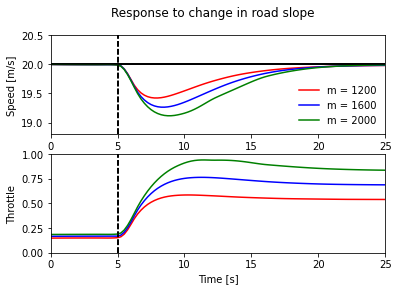

In [ ]:
# Define the time and input vectors
T = np.linspace(0, 25, 101)
vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta0 = np.zeros(T.shape)

# Now simulate the effect of a hill at t = 5 seconds
plt.figure()
plt.suptitle('Response to change in road slope')
theta_hill = np.array([
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T])

subplots = [None, None]
linecolor = ['red', 'blue', 'green']
handles = []
for i, m in enumerate([1200, 1600, 2000]):
    # Compute the equilibrium state for the system
    X0, U0 = ct.find_eqpt(
        cruise_tf, [vref[0], 0], [vref[0], gear[0], theta0[0]],
        iu=[1, 2], y0=[vref[0], 0], iy=[0], params={'m':m})

    t, y = ct.input_output_response(
        cruise_tf, T, [vref, gear, theta_hill], X0, params={'m':m})

    subplots = cruise_plot(cruise_tf, t, y, t_hill=5, subplots=subplots,
                           linetype=linecolor[i][0] + '-')
    handles.append(mlines.Line2D([], [], color=linecolor[i], linestyle='-',
                                 label="m = %d" % m))

# Add labels to the plots
plt.sca(subplots[0])
plt.ylabel('Speed [m/s]')
plt.legend(handles=handles, frameon=False, loc='lower right');

plt.sca(subplots[1])
plt.ylabel('Throttle')
plt.xlabel('Time [s]');

In [ ]:
def pi_update(t, x, u, params={}):
    # Get the controller parameters that we need
    ki = params.get('ki', 0.1)
    kaw = params.get('kaw', 2)  # anti-windup gain

    # Assign variables for inputs and states (for readability)
    v = u[0]                    # current velocity
    vref = u[1]                 # reference velocity
    z = x[0]                    # integrated error

    # Compute the nominal controller output (needed for anti-windup)
    u_a = pi_output(t, x, u, params)

    # Compute anti-windup compensation (scale by ki to account for structure)
    u_aw = kaw/ki * (np.clip(u_a, 0, 1) - u_a) if ki != 0 else 0

    # State is the integrated error, minus anti-windup compensation
    return (vref - v) + u_aw

def pi_output(t, x, u, params={}):
    # Get the controller parameters that we need
    kp = params.get('kp', 0.5)
    ki = params.get('ki', 0.1)

    # Assign variables for inputs and states (for readability)
    v = u[0]                    # current velocity
    vref = u[1]                 # reference velocity
    z = x[0]                    # integrated error

    # PI controller
    return kp * (vref - v) + ki * z

control_pi = ct.NonlinearIOSystem(
    pi_update, pi_output, name='control',
    inputs = ['v', 'vref'], outputs = ['u'], states = ['z'],
    params = {'kp':0.5, 'ki':0.1})

# Create the closed loop system
cruise_pi = ct.InterconnectedSystem(
    (vehicle, control_pi), name='cruise',
    connections=(
        ('vehicle.u', 'control.u'),
        ('control.v', 'vehicle.v')),
    inplist=('control.vref', 'vehicle.gear', 'vehicle.theta'),
    outlist=('control.u', 'vehicle.v'), outputs=['u', 'v'])

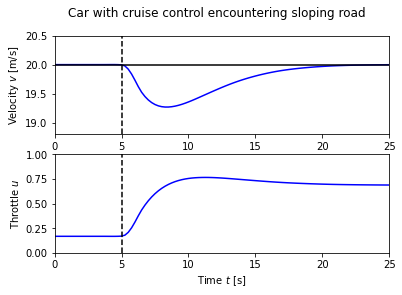

In [ ]:
# Compute the equilibrium throttle setting for the desired speed
X0, U0, Y0 = ct.find_eqpt(
    cruise_pi, [vref[0], 0], [vref[0], gear[0], theta0[0]],
    y0=[0, vref[0]], iu=[1, 2], iy=[1], return_y=True)

# Now simulate the effect of a hill at t = 5 seconds
plt.figure()
plt.suptitle('Car with cruise control encountering sloping road')
theta_hill = [
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T]
t, y = ct.input_output_response(
    cruise_pi, T, [vref, gear, theta_hill], X0)
cruise_plot(cruise_pi, t, y);

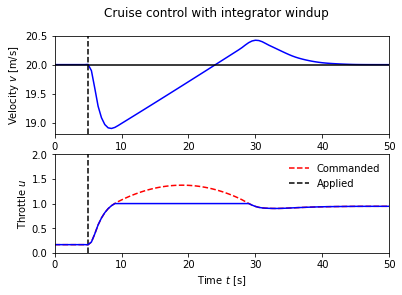

In [ ]:
plt.figure()
plt.suptitle('Cruise control with integrator windup')
T = np.linspace(0, 50, 101)
vref = 20 * np.ones(T.shape)
theta_hill = [
    0 if t <= 5 else
    6./180. * pi * (t-5) if t <= 6 else
    6./180. * pi for t in T]
t, y = ct.input_output_response(
    cruise_pi, T, [vref, gear, theta_hill], X0,
    params={'kaw':0})
cruise_plot(cruise_pi, t, y, antiwindup=True);

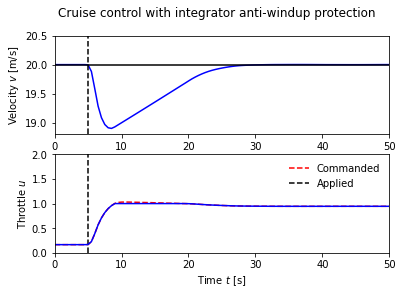

In [ ]:
plt.figure()
plt.suptitle('Cruise control with integrator anti-windup protection')
t, y = ct.input_output_response(
    cruise_pi, T, [vref, gear, theta_hill], X0,
    params={'kaw':2.})
cruise_plot(cruise_pi, t, y, antiwindup=True);

In [ ]:
##Describing function analysis

In [ ]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import math

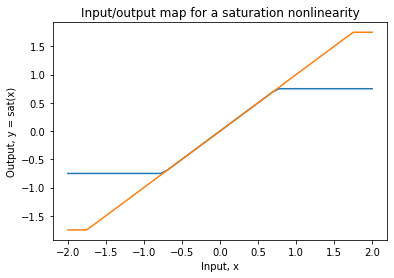

In [ ]:
saturation=ct.saturation_nonlinearity(0.75)
x = np.linspace(-2, 2, 50)
plt.plot(x, saturation(x))
plt.xlabel("Input, x")
plt.ylabel("Output, y = sat(x)")
plt.title("Input/output map for a saturation nonlinearity");

saturation=ct.saturation_nonlinearity(1.75)
x = np.linspace(-2, 2, 50)
plt.plot(x, saturation(x))
plt.xlabel("Input, x")
plt.ylabel("Output, y = sat(x)")
plt.title("Input/output map for a saturation nonlinearity");

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


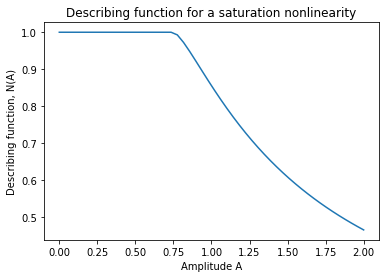

In [ ]:
amp_range = np.linspace(0, 2, 50)
plt.plot(amp_range, ct.describing_function(saturation, amp_range))
plt.xlabel("Amplitude A")
plt.ylabel("Describing function, N(A)")
plt.title("Describing function for a saturation nonlinearity");

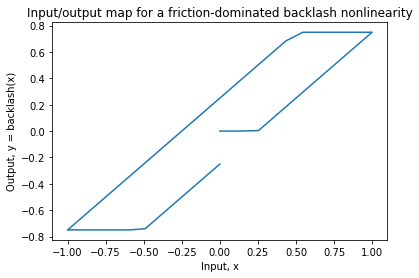

In [ ]:
backlash = ct.friction_backlash_nonlinearity(0.5)
theta = np.linspace(0, 2*np.pi, 50)
x = np.sin(theta)
plt.plot(x, [backlash(z) for z in x])
plt.xlabel("Input, x")
plt.ylabel("Output, y = backlash(x)")
plt.title("Input/output map for a friction-dominated backlash nonlinearity");

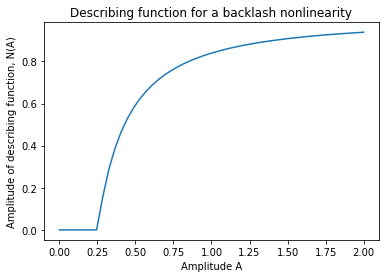

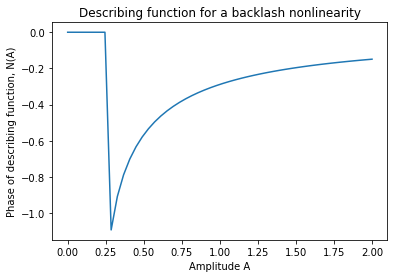

In [ ]:
amp_range = np.linspace(0, 2, 50)
N_a = ct.describing_function(backlash, amp_range)

plt.figure()
plt.plot(amp_range, abs(N_a))
plt.xlabel("Amplitude A")
plt.ylabel("Amplitude of describing function, N(A)")
plt.title("Describing function for a backlash nonlinearity")

plt.figure()
plt.plot(amp_range, np.angle(N_a))
plt.xlabel("Amplitude A")
plt.ylabel("Phase of describing function, N(A)")
plt.title("Describing function for a backlash nonlinearity");

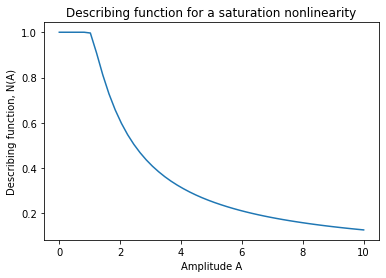

In [ ]:
# Define a saturation nonlinearity as a simple function
def my_saturation(x):
    if abs(x) >= 1:
        return math.copysign(1, x)
    else:
        return x

amp_range = np.linspace(0, 10, 50)
plt.plot(amp_range, ct.describing_function(my_saturation, amp_range).real)
plt.xlabel("Amplitude A")
plt.ylabel("Describing function, N(A)")
plt.title("Describing function for a saturation nonlinearity");

[(3.3439778395630912, 1.4142156916793662)]

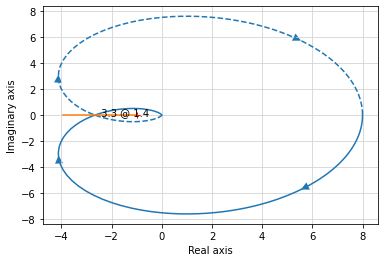

In [ ]:
# Linear dynamics
H_simple = ct.tf([8], [1, 2, 2, 1])
omega = np.logspace(-3, 3, 500)

# Nonlinearity
F_saturation = ct.saturation_nonlinearity(1)
amp = np.linspace(00, 5, 50)

# Describing function plot (return value = amp, freq)
ct.describing_function_plot(H_simple, F_saturation, amp, omega)

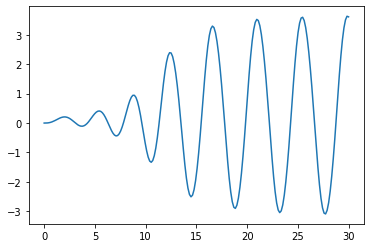

In [ ]:
# Create an I/O system simulation to see what happens
io_saturation = ct.NonlinearIOSystem(
    None,
    lambda t, x, u, params: F_saturation(u),
    inputs=1, outputs=1
)

sys = ct.feedback(ct.tf2io(H_simple), io_saturation)
T = np.linspace(0, 30, 200)
t, y = ct.input_output_response(sys, T, 0.1, 0)
plt.plot(t, y);

[(0.6260158833534124, 0.3102619497970334),
 (0.8741930326852424, 1.2156410944770244)]

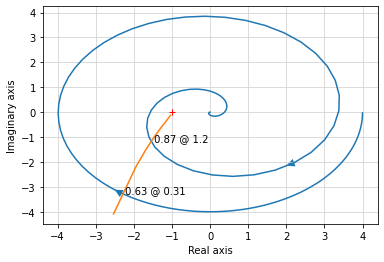

In [ ]:
# Linear dynamics
H_simple = ct.tf([1], [1, 2, 2, 1])
H_multiple = H_simple * ct.tf(*ct.pade(5, 4)) * 4
omega = np.logspace(-3, 3, 500)

# Nonlinearity
F_backlash = ct.friction_backlash_nonlinearity(1)
amp = np.linspace(0.6, 5, 50)

# Describing function plot
ct.describing_function_plot(H_multiple, F_backlash, amp, omega, mirror_style=False)

In [ ]:
# Model Predictive Control: Aircraft Model/

In [ ]:
import control as ct
import numpy as np
import control.optimal as opt
import matplotlib.pyplot as plt

In [ ]:
# model of an aircraft discretized with 0.2s sampling time
# Source: https://www.mpt3.org/UI/RegulationProblem
A = [[0.99, 0.01, 0.18, -0.09,   0],
     [   0, 0.94,    0,  0.29,   0],
     [   0, 0.14, 0.81,  -0.9,   0],
     [   0, -0.2,    0,  0.95,   0],
     [   0, 0.09,    0,     0, 0.9]]
B = [[ 0.01, -0.02],
     [-0.14,     0],
     [ 0.05,  -0.2],
     [ 0.02,     0],
     [-0.01, 0]]
C = [[0, 1, 0, 0, -1],
     [0, 0, 1, 0,  0],
     [0, 0, 0, 1,  0],
     [1, 0, 0, 0,  0]]
model = ct.ss2io(ct.ss(A, B, C, 0, 0.2))

# For the simulation we need the full state output
sys = ct.ss2io(ct.ss(A, B, np.eye(5), 0, 0.2))

# compute the steady state values for a particular value of the input
ud = np.array([0.8, -0.3])
xd = np.linalg.inv(np.eye(5) - A) @ B @ ud
yd = C @ xd

In [ ]:
# computed values will be used as references for the desired
# steady state which can be added using "reference" filter
# model.u.with('reference');
# model.u.reference = us;
# model.y.with('reference');
# model.y.reference = ys;

# provide constraints on the system signals
constraints = [opt.input_range_constraint(sys, [-5, -6], [5, 6])]

# provide penalties on the system signals
Q = model.C.transpose() @ np.diag([10, 10, 10, 10]) @ model.C
R = np.diag([3, 2])
cost = opt.quadratic_cost(model, Q, R, x0=xd, u0=ud)

# online MPC controller object is constructed with a horizon 6
ctrl = opt.create_mpc_iosystem(model, np.arange(0, 6) * 0.2, cost, constraints)

In [ ]:
# Define an I/O system implementing model predictive control
loop = ct.feedback(sys, ctrl, 1)
print(loop)

System: sys[7]
Inputs (2): u[0], u[1], 
Outputs (5): y[0], y[1], y[2], y[3], y[4], 
States (17): sys[5]_x[0], sys[5]_x[1], sys[5]_x[2], sys[5]_x[3], sys[5]_x[4], sys[6]_x[0], sys[6]_x[1], sys[6]_x[2], sys[6]_x[3], sys[6]_x[4], sys[6]_x[5], sys[6]_x[6], sys[6]_x[7], sys[6]_x[8], sys[6]_x[9], sys[6]_x[10], sys[6]_x[11], 


In [ ]:
import time

# loop = ClosedLoop(ctrl, model);
# x0 = [0, 0, 0, 0, 0]
Nsim = 60

start = time.time()
tout, xout = ct.input_output_response(loop, np.arange(0, Nsim) * 0.2, 0, 0)
end = time.time()
print("Computation time = %g seconds" % (end-start))

/usr/local/lib/python3.7/dist-packages/control/optimal.py:806: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Inequality constraints incompatible
  "scipy.optimize.minimize returned " + res.message, UserWarning)


Computation time = 9.29298 seconds


array([-1.7021, -0.083578, 0.35719, 0.028494, -0.010999])

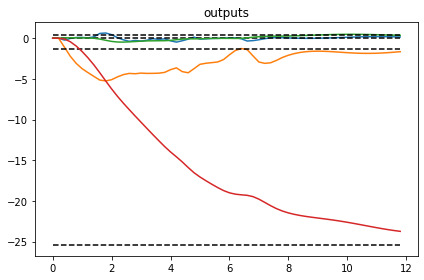

In [ ]:
# Plot the results
# plt.subplot(2, 1, 1)
for i, y in enumerate(C @ xout):
    plt.plot(tout, y)
    plt.plot(tout, yd[i] * np.ones(tout.shape), 'k--')
plt.title('outputs')

# plt.subplot(2, 1, 2)
# plt.plot(t, u);
# plot(np.range(Nsim), us*ones(1, Nsim), 'k--')
# plt.title('inputs')

plt.tight_layout()

# Print the final error
xd - xout[:,-1]

In [ ]:
# Vehicle steering

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
ct.use_fbs_defaults()

In [ ]:
def vehicle_update(t, x, u, params):
    # Get the parameters for the model
    a = params.get('refoffset', 1.5)        # offset to vehicle reference point
    b = params.get('wheelbase', 3.)         # vehicle wheelbase
    maxsteer = params.get('maxsteer', 0.5)  # max steering angle (rad)

    # Saturate the steering input
    delta = np.clip(u[1], -maxsteer, maxsteer)
    alpha = np.arctan2(a * np.tan(delta), b)

    # Return the derivative of the state
    return np.array([
        u[0] * np.cos(x[2] + alpha),    # xdot = cos(theta + alpha) v
        u[0] * np.sin(x[2] + alpha),    # ydot = sin(theta + alpha) v
        (u[0] / b) * np.tan(delta)      # thdot = v/l tan(phi)
    ])

def vehicle_output(t, x, u, params):
    return x[0:2]

# Default vehicle parameters (including nominal velocity)
vehicle_params={'refoffset': 1.5, 'wheelbase': 3, 'velocity': 15,
                'maxsteer': 0.5}

# Define the vehicle steering dynamics as an input/output system
vehicle = ct.NonlinearIOSystem(
    vehicle_update, vehicle_output, states=3, name='vehicle',
    inputs=('v', 'delta'), outputs=('x', 'y'), params=vehicle_params)

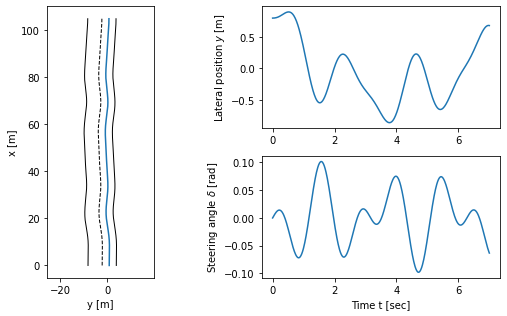

In [ ]:
# System parameters
wheelbase = vehicle_params['wheelbase']
v0 = vehicle_params['velocity']

# Control inputs
T_curvy = np.linspace(0, 7, 500)
v_curvy = v0*np.ones(T_curvy.shape)
delta_curvy = 0.1*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.0025*np.sin(T_curvy*np.pi/7)
u_curvy = [v_curvy, delta_curvy]
X0_curvy = [0, 0.8, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    vehicle, T_curvy, u_curvy, X0_curvy, params=vehicle_params, return_x=True)

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Plot the resulting trajectory (and some road boundaries)
plt.subplot(1, 4, 2)
plt.plot(y_curvy[1], y_curvy[0])
plt.plot(y_curvy[1] - 9/np.cos(x_curvy[2]), y_curvy[0], 'k-', linewidth=1)
plt.plot(y_curvy[1] - 3/np.cos(x_curvy[2]), y_curvy[0], 'k--', linewidth=1)
plt.plot(y_curvy[1] + 3/np.cos(x_curvy[2]), y_curvy[0], 'k-', linewidth=1)

plt.xlabel('y [m]')
plt.ylabel('x [m]');
plt.axis('Equal')

# Plot the lateral position
plt.subplot(2, 2, 2)
plt.plot(t_curvy, y_curvy[1])
plt.ylabel('Lateral position $y$ [m]')

# Plot the steering angle
plt.subplot(2, 2, 4)
plt.plot(t_curvy, delta_curvy)
plt.ylabel('Steering angle $\\delta$ [rad]')
plt.xlabel('Time t [sec]')
plt.tight_layout()

In [ ]:
# Define the lateral dynamics as a subset of the full vehicle steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: vehicle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: vehicle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('phi'), outputs=('y')
)

# Compute the linearization at velocity v0 = 15 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=vehicle_params)

# Normalize dynamics using state [x1/b, x2] and timescale v0 t / b
b = vehicle_params['wheelbase']
v0 = vehicle_params['velocity']
lateral_transformed = ct.similarity_transform(
    lateral_linearized, [[1/b, 0], [0, 1]], timescale=v0/b)

# Set the output to be the normalized state x1/b
lateral_normalized = lateral_transformed * (1/b)
print("Linearized system dynamics:\n")
print(lateral_normalized)

# Save the system matrices for later use
A = lateral_normalized.A
B = lateral_normalized.B
C = lateral_normalized.C

Linearized system dynamics:

A = [[0 1]
     [0 0]]

B = [[0.5]
     [1]]

C = [[1 0]]

D = [[0]]



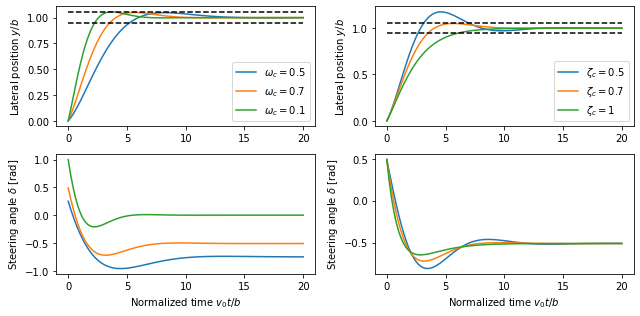

In [ ]:
# Utility function to place poles for the normalized vehicle steering system
def normalized_place(wc, zc):
    # Get the dynamics and input matrices, for later use
    A, B = lateral_normalized.A, lateral_normalized.B

    # Compute the eigenvalues from the characteristic polynomial
    eigs = np.roots([1, 2*zc*wc, wc**2])

    # Compute the feedback gain using eigenvalue placement
    K = ct.place_varga(A, B, eigs)

    # Create a new system representing the closed loop response
    clsys = ct.StateSpace(A - B @ K, B, lateral_normalized.C, 0)

    # Compute the feedforward gain based on the zero frequency gain of the closed loop
    kf = np.real(1/clsys(0))

    # Scale the input by the feedforward gain
    clsys *= kf

    # Return gains and closed loop system dynamics
    return K, kf, clsys

# Utility function to plot simulation results for normalized vehicle steering system
def normalized_plot(t, y, u, inpfig, outfig):
    plt.sca(outfig)
    plt.plot(t, y)
    plt.sca(inpfig)
    plt.plot(t, u[0])

# Utility function to label plots of normalized vehicle steering system
def normalized_label(inpfig, outfig):
    plt.sca(inpfig)
    plt.xlabel('Normalized time $v_0 t / b$')
    plt.ylabel('Steering angle $\delta$ [rad]')

    plt.sca(outfig)
    plt.ylabel('Lateral position $y/b$')
    plt.plot([0, 20], [0.95, 0.95], 'k--')
    plt.plot([0, 20], [1.05, 1.05], 'k--')

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Explore range of values for omega_c, with zeta_c = 0.7
outfig = plt.subplot(2, 2, 1)
inpfig = plt.subplot(2, 2, 3)
zc = 0.7
for wc in [0.5, 0.7, 1]:
    # Place the poles of the system
    K, kf, clsys = normalized_place(wc, zc)

    # Compute the step response
    t, y, x = ct.step_response(clsys, np.linspace(0, 20, 100), return_x=True)

    # Compute the input used to generate the control response
    u = -K @ x + kf * 1

    # Plot the results
    normalized_plot(t, y, u, inpfig, outfig)

# Add labels to the figure
normalized_label(inpfig, outfig)
plt.legend(('$\omega_c = 0.5$', '$\omega_c = 0.7$', '$\omega_c = 0.1$'))

# Explore range of values for zeta_c, with omega_c = 0.07
outfig = plt.subplot(2, 2, 2)
inpfig = plt.subplot(2, 2, 4)
wc = 0.7
for zc in [0.5, 0.7, 1]:
    # Place the poles of the system
    K, kf, clsys = normalized_place(wc, zc)

    # Compute the step response
    t, y, x = ct.step_response(clsys, np.linspace(0, 20, 100), return_x=True)

    # Compute the input used to generate the control response
    u = -K @ x + kf * 1

    # Plot the results
    normalized_plot(t, y, u, inpfig, outfig)

# Add labels to the figure
normalized_label(inpfig, outfig)
plt.legend(('$\zeta_c = 0.5$', '$\zeta_c = 0.7$', '$\zeta_c = 1$'))
plt.tight_layout()

In [ ]:
# Find the eigenvalue from the characteristic polynomial
wo = 1          # bandwidth for the observer
zo = 0.7        # damping ratio for the observer
eigs = np.roots([1, 2*zo*wo, wo**2])

# Compute the estimator gain using eigenvalue placement
L = np.transpose(
    ct.place(np.transpose(A), np.transpose(C), eigs))
print("L = ", L)

# Create a linear model of the lateral dynamics driving the estimator
est = ct.StateSpace(A - L @ C, np.block([[B, L]]), np.eye(2), np.zeros((2,2)))

L =  [[1.4]
 [1]]


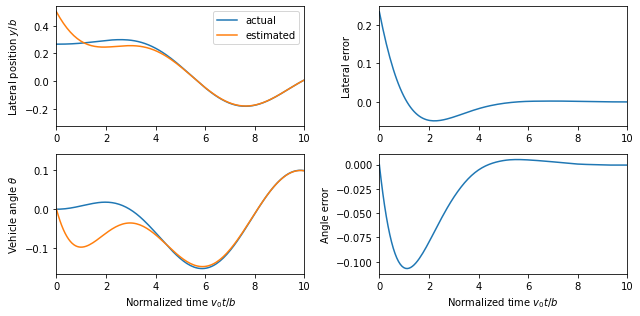

In [ ]:
# Convert the curvy trajectory into normalized coordinates
x_ref = x_curvy[0] / wheelbase
y_ref = x_curvy[1] / wheelbase
theta_ref = x_curvy[2]
tau = v0 * T_curvy / b

# Simulate the estimator, with a small initial error in y position
t, y_est, x_est = ct.forced_response(est, tau, [delta_curvy, y_ref], [0.5, 0], return_x=True)

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Plot the actual and estimated states
ax = plt.subplot(2, 2, 1)
plt.plot(t, y_ref)
plt.plot(t, x_est[0])
ax.set(xlim=[0, 10])
plt.legend(['actual', 'estimated'])
plt.ylabel('Lateral position $y/b$')

ax = plt.subplot(2, 2, 2)
plt.plot(t, x_est[0] - y_ref)
ax.set(xlim=[0, 10])
plt.ylabel('Lateral error')

ax = plt.subplot(2, 2, 3)
plt.plot(t, theta_ref)
plt.plot(t, x_est[1])
ax.set(xlim=[0, 10])
plt.xlabel('Normalized time $v_0 t / b$')
plt.ylabel('Vehicle angle $\\theta$')

ax = plt.subplot(2, 2, 4)
plt.plot(t, x_est[1] - theta_ref)
ax.set(xlim=[0, 10])
plt.xlabel('Normalized time $v_0 t / b$')
plt.ylabel('Angle error')
plt.tight_layout()

K =  [[0.49 0.7448]]
kf =  0.4899999999999182


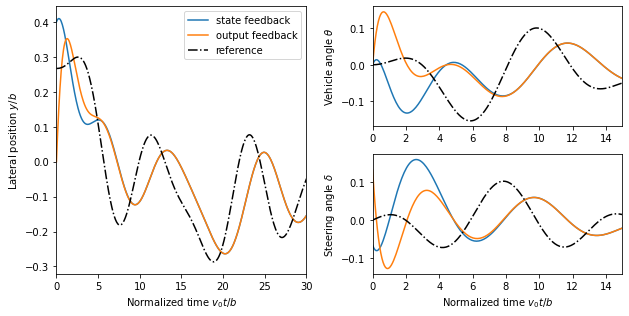

In [ ]:
# Compute the feedback gains
# K, kf, clsys = normalized_place(1, 0.707)     # Gains from MATLAB
# K, kf, clsys = normalized_place(0.07, 0.707)  # Original gains
K, kf, clsys = normalized_place(0.7, 0.707)       # Final gains

# Print out the gains
print("K = ", K)
print("kf = ", kf)

# Construct an output-based controller for the system
clsys = ct.StateSpace(
    np.block([[A, -B@K], [L@C, A - B@K - L@C]]),
    np.block([[B], [B]]) * kf,
    np.block([[C, np.zeros(C.shape)], [np.zeros(C.shape), C]]),
    np.zeros((2,1)))

# Simulate the system
t, y, x = ct.forced_response(clsys, tau, y_ref, [0.4, 0, 0.0, 0], return_x=True)

# Calcaluate the input used to generate the control response
u_sfb = kf * y_ref - K @ x[0:2]
u_ofb = kf * y_ref - K @ x[2:4]

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Plot the actual and estimated states
ax = plt.subplot(1, 2, 1)
plt.plot(t, x[0])
plt.plot(t, x[2])
plt.plot(t, y_ref, 'k-.')
ax.set(xlim=[0, 30])
plt.legend(['state feedback', 'output feedback', 'reference'])
plt.xlabel('Normalized time $v_0 t / b$')
plt.ylabel('Lateral position $y/b$')

ax = plt.subplot(2, 2, 2)
plt.plot(t, x[1])
plt.plot(t, x[3])
plt.plot(t, theta_ref, 'k-.')
ax.set(xlim=[0, 15])
plt.ylabel('Vehicle angle $\\theta$')

ax = plt.subplot(2, 2, 4)
plt.plot(t, u_sfb[0])
plt.plot(t, u_ofb[0])
plt.plot(t, delta_curvy, 'k-.')
ax.set(xlim=[0, 15])
plt.xlabel('Normalized time $v_0 t / b$')
plt.ylabel('Steering angle $\\delta$')
plt.tight_layout()

In [ ]:
import control.flatsys as fs

# Function to take states, inputs and return the flat flag
def vehicle_flat_forward(x, u, params={}):
    # Get the parameter values
    b = params.get('wheelbase', 3.)

    # Create a list of arrays to store the flat output and its derivatives
    zflag = [np.zeros(3), np.zeros(3)]

    # Flat output is the x, y position of the rear wheels
    zflag[0][0] = x[0]
    zflag[1][0] = x[1]

    # First derivatives of the flat output
    zflag[0][1] = u[0] * np.cos(x[2])  # dx/dt
    zflag[1][1] = u[0] * np.sin(x[2])  # dy/dt

    # First derivative of the angle
    thdot = (u[0]/b) * np.tan(u[1])

    # Second derivatives of the flat output (setting vdot = 0)
    zflag[0][2] = -u[0] * thdot * np.sin(x[2])
    zflag[1][2] =  u[0] * thdot * np.cos(x[2])

    return zflag

# Function to take the flat flag and return states, inputs
def vehicle_flat_reverse(zflag, params={}):
    # Get the parameter values
    b = params.get('wheelbase', 3.)

    # Create a vector to store the state and inputs
    x = np.zeros(3)
    u = np.zeros(2)

    # Given the flat variables, solve for the state
    x[0] = zflag[0][0]  # x position
    x[1] = zflag[1][0]  # y position
    x[2] = np.arctan2(zflag[1][1], zflag[0][1])  # tan(theta) = ydot/xdot

    # And next solve for the inputs
    u[0] = zflag[0][1] * np.cos(x[2]) + zflag[1][1] * np.sin(x[2])
    thdot_v = zflag[1][2] * np.cos(x[2]) - zflag[0][2] * np.sin(x[2])
    u[1] = np.arctan2(thdot_v, u[0]**2 / b)

    return x, u

vehicle_flat = fs.FlatSystem(vehicle_flat_forward, vehicle_flat_reverse, inputs=2, states=3)

In [ ]:
# Utility function to plot lane change trajectory
def plot_vehicle_lanechange(traj):
    # Create the trajectory
    t = np.linspace(0, Tf, 100)
    x, u = traj.eval(t)

    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[9, 4.5])

    # Plot the trajectory in xy coordinate
    plt.subplot(1, 4, 2)
    plt.plot(x[1], x[0])
    plt.xlabel('y [m]')
    plt.ylabel('x [m]')

    # Add lane lines and scale the axis
    plt.plot([-4, -4], [0, x[0, -1]], 'k-', linewidth=1)
    plt.plot([0, 0], [0, x[0, -1]], 'k--', linewidth=1)
    plt.plot([4, 4], [0, x[0, -1]], 'k-', linewidth=1)
    plt.axis([-10, 10, -5, x[0, -1] + 5])

    # Time traces of the state and input
    plt.subplot(2, 4, 3)
    plt.plot(t, x[1])
    plt.ylabel('y [m]')

    plt.subplot(2, 4, 4)
    plt.plot(t, x[2])
    plt.ylabel('theta [rad]')

    plt.subplot(2, 4, 7)
    plt.plot(t, u[0])
    plt.xlabel('Time t [sec]')
    plt.ylabel('v [m/s]')
    # plt.axis([0, t[-1], u0[0] - 1, uf[0] + 1])

    plt.subplot(2, 4, 8)
    plt.plot(t, u[1]);
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\delta$ [rad]')
    plt.tight_layout()

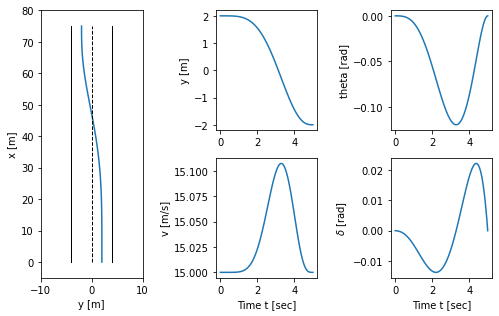

In [ ]:
# Define the endpoints of the trajectory
x0 = [0., 2., 0.]; u0 = [15, 0.]
xf = [75, -2., 0.]; uf = [15, 0.]
Tf = xf[0] / uf[0]

# Define a set of basis functions to use for the trajectories
poly = fs.PolyFamily(8)

# Find a trajectory between the initial condition and the final condition
traj1 = fs.point_to_point(vehicle_flat, Tf, x0, u0, xf, uf, basis=poly)
plot_vehicle_lanechange(traj1)

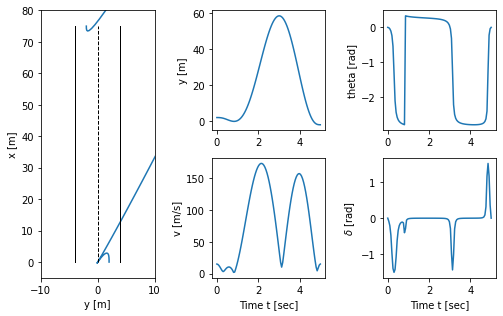

In [ ]:
bezier = fs.BezierFamily(8)
traj2 = fs.point_to_point(vehicle_flat, Tf, x0, u0, xf, uf, basis=bezier)
plot_vehicle_lanechange(traj2)

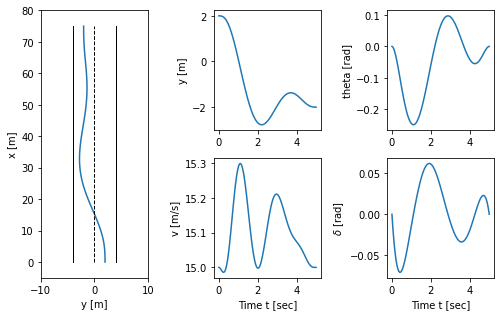

In [ ]:
timepts = np.linspace(0, Tf, 12)
poly = fs.PolyFamily(8)
traj_cost = opt.quadratic_cost(
    vehicle_flat, np.diag([0, 0.1, 0]), np.diag([0.1, 10]), x0=xf, u0=uf)
constraints = [
     opt.input_range_constraint(vehicle_flat, [8, -0.1], [12, 0.1]) ]

traj3 = fs.point_to_point(
     vehicle_flat, timepts, x0, u0, xf, uf, cost=traj_cost, basis=poly
)
plot_vehicle_lanechange(traj3)

In [ ]:
# Magnitude of the steering input (half maximum)
Msteer = vehicle_params['maxsteer'] / 2

# Create a linearized model of the system going forward at 2 m/s
forward_lateral = ct.linearize(lateral, [0, 0], [0], params={'velocity': 2})
forward_tf = ct.ss2tf(forward_lateral)[0, 0]
print("Forward TF = ", forward_tf)

# Create a linearized model of the system going in reverise at 1 m/s
reverse_lateral = ct.linearize(lateral, [0, 0], [0], params={'velocity': -2})
reverse_tf = ct.ss2tf(reverse_lateral)[0, 0]
print("Reverse TF = ", reverse_tf)

Forward TF =  
          s + 1.333
-----------------------------
s^2 + 7.828e-16 s - 1.848e-16

Reverse TF =  
         -s + 1.333
-----------------------------
s^2 - 7.828e-16 s - 1.848e-16



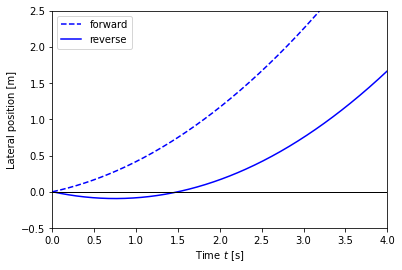

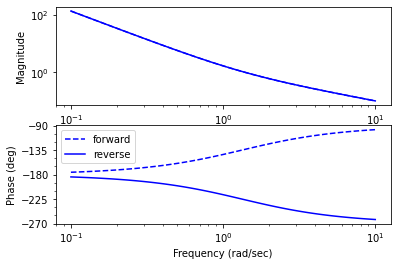

In [ ]:
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure()

# Forward motion
t, y = ct.step_response(forward_tf * Msteer, np.linspace(0, 4, 500))
plt.plot(t, y, 'b--')

# Reverse motion
t, y = ct.step_response(reverse_tf * Msteer, np.linspace(0, 4, 500))
plt.plot(t, y, 'b-')

# Add labels and reference lines
plt.axis([0, 4, -0.5, 2.5])
plt.legend(['forward', 'reverse'], loc='upper left')
plt.xlabel('Time $t$ [s]')
plt.ylabel('Lateral position [m]')
plt.plot([0, 4], [0, 0], 'k-', linewidth=1)

# Plot the Bode plots
plt.figure()
plt.subplot(1, 2, 2)
ct.bode_plot(forward_tf[0, 0], np.logspace(-1, 1, 100), color='b', linestyle='--')
ct.bode_plot(reverse_tf[0, 0], np.logspace(-1, 1, 100), color='b', linestyle='-')
plt.legend(('forward', 'reverse'));

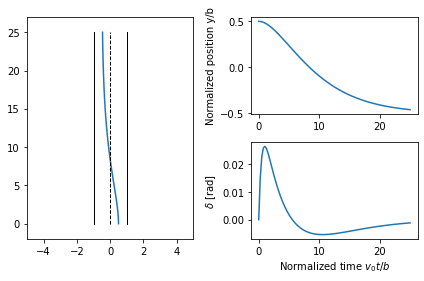

In [ ]:
# Define the desired response of the system
a = 0.2
P = ct.ss2tf(lateral_normalized)
Fm = ct.TransferFunction([a**2], [1, 2*a, a**2])
Fr = Fm / P

# Compute the step response of the feedforward components
t, y_ffwd = ct.step_response(Fm, np.linspace(0, 25, 100))
t, delta_ffwd = ct.step_response(Fr, np.linspace(0, 25, 100))

# Scale and shift to correspond to lane change (-2 to +2)
y_ffwd = 0.5 - 1 * y_ffwd
delta_ffwd *= 1

# Overhead view
plt.subplot(1, 2, 1)
plt.plot(y_ffwd, t)
plt.plot(-1*np.ones(t.shape), t, 'k-', linewidth=1)
plt.plot(0*np.ones(t.shape), t, 'k--', linewidth=1)
plt.plot(1*np.ones(t.shape), t, 'k-', linewidth=1)
plt.axis([-5, 5, -2, 27])

# Plot the response
plt.subplot(2, 2, 2)
plt.plot(t, y_ffwd)
# plt.axis([0, 10, -5, 5])
plt.ylabel('Normalized position y/b')

plt.subplot(2, 2, 4)
plt.plot(t, delta_ffwd)
# plt.axis([0, 10, -1, 1])
plt.ylabel('$\\delta$ [rad]')
plt.xlabel('Normalized time $v_0 t / b$');

plt.tight_layout()

K =  [100 -35.86]
L =  [28.28 400]
C(s) =  
-1.152e+04 s + 4e+04
--------------------
s^2 + 42.42 s + 6658



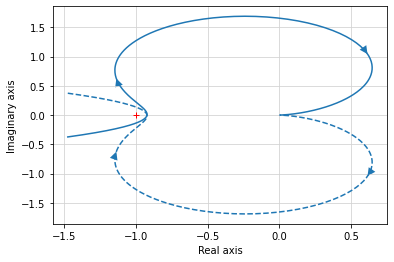

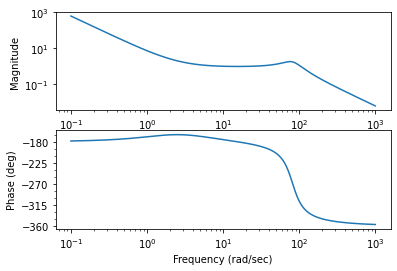

In [ ]:
# Compute the feedback gain using eigenvalue placement
wc = 10
zc = 0.707
eigs = np.roots([1, 2*zc*wc, wc**2])
K = ct.place(A, B, eigs)
kr = np.real(1/clsys(0))
print("K = ", np.squeeze(K))

# Compute the estimator gain using eigenvalue placement
wo = 20
zo = 0.707
eigs = np.roots([1, 2*zo*wo, wo**2])
L = np.transpose(
    ct.place(np.transpose(A), np.transpose(C), eigs))
print("L = ", np.squeeze(L))

# Construct an output-based controller for the system
C1 = ct.ss2tf(ct.StateSpace(A - B@K - L@C, L, K, 0))
print("C(s) = ", C1)

# Compute the loop transfer function and plot Nyquist, Bode
L1 = P * C1
plt.figure(); ct.nyquist_plot(L1, np.logspace(0.5, 3, 500))
plt.figure(); ct.bode_plot(L1, np.logspace(-1, 3, 500));


In [ ]:
# Modified control law
wc = 10
zc = 2.6
eigs = np.roots([1, 2*zc*wc, wc**2])
K = ct.place(A, B, eigs)
kr = np.real(1/clsys(0))
print("K = ", np.squeeze(K))

# Construct an output-based controller for the system
C2 = ct.ss2tf(ct.StateSpace(A - B@K - L@C, L, K, 0))
print("C(s) = ", C2)

K =  [100 2]
C(s) =  
   3628 s + 4e+04
---------------------
s^2 + 80.28 s + 156.6



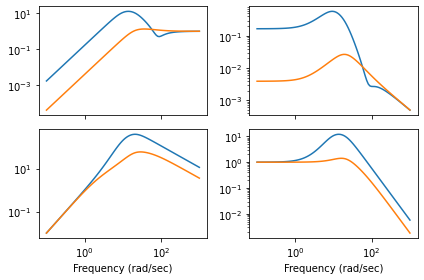

In [ ]:
# Plot the gang of four for the two designs
ct.gangof4(P, C1, np.logspace(-1, 3, 100))
ct.gangof4(P, C2, np.logspace(-1, 3, 100))

In [ ]:
# Vertical takeoff and landing aircraft

In [ ]:
from numpy import *             # Grab all of the NumPy functions
from matplotlib.pyplot import * # Grab MATLAB plotting functions
from control.matlab import *    # MATLAB-like functions
%matplotlib inline

In [ ]:
m = 4                         # mass of aircraft
J = 0.0475                    # inertia around pitch axis
r = 0.25                      # distance to center of force
g = 9.8                       # gravitational constant
c = 0.05                      # damping factor (estimated)

In [ ]:
# State space dynamics
xe = [0, 0, 0, 0, 0, 0]         # equilibrium point of interest
ue = [0, m*g]                   # (note these are lists, not matrices)

In [ ]:
# Dynamics matrix (use matrix type so that * works for multiplication)
# Note that we write A and B here in full generality in case we want
# to test different xe and ue.
A = matrix(
   [[ 0,    0,    0,    1,    0,    0],
    [ 0,    0,    0,    0,    1,    0],
    [ 0,    0,    0,    0,    0,    1],
    [ 0, 0, (-ue[0]*sin(xe[2]) - ue[1]*cos(xe[2]))/m, -c/m, 0, 0],
    [ 0, 0, (ue[0]*cos(xe[2]) - ue[1]*sin(xe[2]))/m, 0, -c/m, 0],
    [ 0,    0,    0,    0,    0,    0 ]])

# Input matrix
B = matrix(
   [[0, 0], [0, 0], [0, 0],
    [cos(xe[2])/m, -sin(xe[2])/m],
    [sin(xe[2])/m,  cos(xe[2])/m],
    [r/J, 0]])

# Output matrix
C = matrix([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
D = matrix([[0, 0], [0, 0]])

In [ ]:
Qx1 = diag([1, 1, 1, 1, 1, 1])
Qu1a = diag([1, 1])
(K, X, E) = lqr(A, B, Qx1, Qu1a); K1a = matrix(K)

In [ ]:
# Our input to the system will only be (x_d, y_d), so we need to
# multiply it by this matrix to turn it into z_d.
Xd = matrix([[1,0,0,0,0,0],
             [0,1,0,0,0,0]]).T

# Closed loop dynamics
H = ss(A-B*K,B*K*Xd,C,D)

# Step response for the first input
x,t = step(H,input=0,output=0,T=linspace(0,10,100))
# Step response for the second input
y,t = step(H,input=1,output=1,T=linspace(0,10,100))

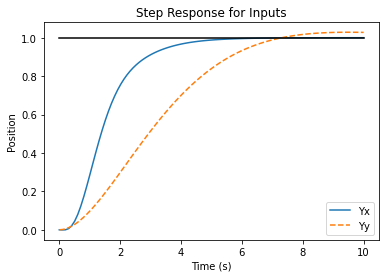

In [ ]:
plot(t,x,'-',t,y,'--')
plot([0, 10], [1, 1], 'k-')
ylabel('Position')
xlabel('Time (s)')
title('Step Response for Inputs')
legend(('Yx', 'Yy'), loc='lower right')
show()

In [ ]:
# Look at different input weightings
Qu1a = diag([1, 1])
K1a, X, E = lqr(A, B, Qx1, Qu1a)
H1ax = H = ss(A-B*K1a,B*K1a*Xd,C,D)

Qu1b = (40**2)*diag([1, 1])
K1b, X, E = lqr(A, B, Qx1, Qu1b)
H1bx = H = ss(A-B*K1b,B*K1b*Xd,C,D)

Qu1c = (200**2)*diag([1, 1])
K1c, X, E = lqr(A, B, Qx1, Qu1c)
H1cx = ss(A-B*K1c,B*K1c*Xd,C,D)

[Y1, T1] = step(H1ax, T=linspace(0,10,100), input=0,output=0)
[Y2, T2] = step(H1bx, T=linspace(0,10,100), input=0,output=0)
[Y3, T3] = step(H1cx, T=linspace(0,10,100), input=0,output=0)

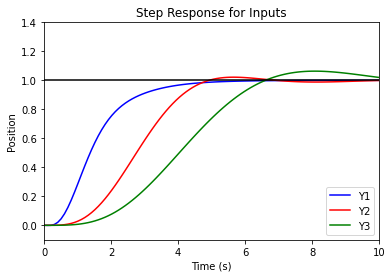

In [ ]:
plot(T1, Y1.T, 'b-', T2, Y2.T, 'r-', T3, Y3.T, 'g-')
plot([0 ,10], [1, 1], 'k-')
title('Step Response for Inputs')
ylabel('Position')
xlabel('Time (s)')
legend(('Y1','Y2','Y3'),loc='lower right')
axis([0, 10, -0.1, 1.4])
show()

In [ ]:
from matplotlib.pyplot import * # Grab MATLAB plotting functions
from control.matlab import *    # MATLAB-like functions

In [ ]:
# System parameters
m = 4                         # mass of aircraft
J = 0.0475                    # inertia around pitch axis
r = 0.25                      # distance to center of force
g = 9.8                       # gravitational constant
c = 0.05                      # damping factor (estimated)

In [ ]:
# Transfer functions for dynamics
Pi = tf([r], [J, 0, 0])       # inner loop (roll)
Po = tf([1], [m, c, 0])       # outer loop (position)

In [ ]:
k = 200
a = 2
b = 50
Ci = k*tf([1, a], [1, b])     # lead compensator
Li = Pi*Ci

In [ ]:
Hi = parallel(feedback(Ci, Pi), -m*g*feedback(Ci*Pi, 1))

In [ ]:
# Now design the lateral control system
a = 0.02
b = 5
K = 2
Co = -K*tf([1, 0.3], [1, 10])         # another lead compensator
Lo = -m*g*Po*Co

In [ ]:
L = Co*Hi*Po
S = feedback(1, L)
T = feedback(L, 1)

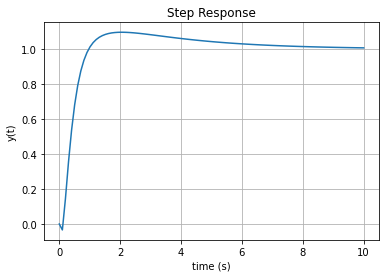

In [ ]:
t, y = step(T, T=linspace(0,10,100))
plot(y, t)
title("Step Response")
grid()
xlabel("time (s)")
ylabel("y(t)")
show()

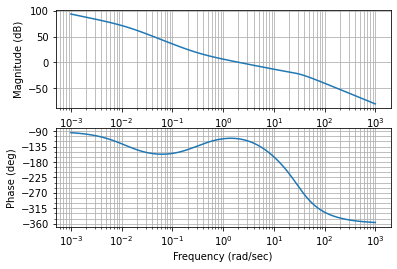

In [ ]:
bode(L)
show()

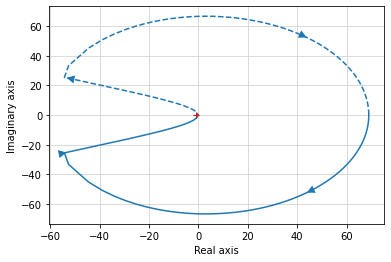

In [ ]:
nyquist(L, (0.0001, 1000))
show()

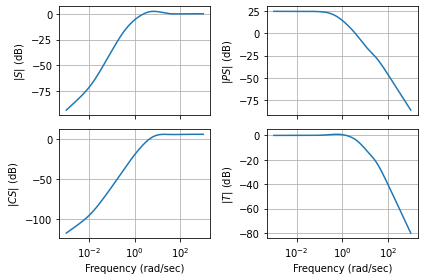

In [ ]:
gangof4(Hi*Po, Co)

In [ ]:
dir(ct)

['ControlArgument',
 'ControlDimension',
 'ControlMIMONotImplemented',
 'ControlNotImplemented',
 'ControlSlycot',
 'DescribingFunctionNonlinearity',
 'FRD',
 'FrequencyResponseData',
 'InputOutputSystem',
 'InterconnectedSystem',
 'LinearICSystem',
 'LinearIOSystem',
 'NonlinearIOSystem',
 'StateSpace',
 'TimeResponseData',
 'TransferFunction',
 '__builtins__',
 '__cached__',
 '__commit__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_version',
 'acker',
 'append',
 'augw',
 'balred',
 'bdalg',
 'bdschur',
 'bode',
 'bode_plot',
 'box_grid',
 'c2d',
 'canonical',
 'canonical_form',
 'care',
 'common_timebase',
 'config',
 'connect',
 'ctrb',
 'ctrlutil',
 'damp',
 'dare',
 'db2mag',
 'dcgain',
 'defaults',
 'delay',
 'descfcn',
 'describing_function',
 'describing_function_plot',
 'dlqe',
 'dlqr',
 'dlyap',
 'drss',
 'dtime',
 'era',
 'evalfr',
 'exception',
 'feedback',
 'find_eqpt',
 'flatsys',
 'forced_response',


In [ ]:
dir(ct.optimal)

['OptimalControlProblem',
 'OptimalControlResult',
 'TimeResponseData',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__warningregistry__',
 'create_mpc_iosystem',
 'ct',
 'input_poly_constraint',
 'input_range_constraint',
 'logging',
 'np',
 'opt',
 'output_poly_constraint',
 'output_range_constraint',
 'quadratic_cost',
 'solve_ocp',
 'sp',
 'state_poly_constraint',
 'state_range_constraint',
 'time',
 'warnings']

In [ ]:
# dir(ct.optimal.create_mpc_iosystem)
# dir(ct.optimal.opt)
dir(ct.optimal.OptimalControlProblem)
# dir(ct.optimal.OptimalControlProblem.compute_mpc)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_coeffs_to_inputs',
 '_constraint_function',
 '_cost_function',
 '_create_mpc_iosystem',
 '_eqconst_function',
 '_inputs_to_coeffs',
 '_print_statistics',
 '_process_initial_guess',
 '_reset_statistics',
 'compute_mpc',
 'compute_trajectory']